# Exercise 1
### Lars Kuehmichel, Nicolas Wolf

### 1 Loading the Dataset

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

import numpy as np
print(data.dtype)


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64


In [14]:
threes = target == 3
eights = target == 8

which = threes | eights

bdata = data[which]
btarget = target[which]

bdata = np.append(bdata, np.ones((bdata.shape[0], 1)), axis=-1)

threes = btarget == 3
eights = btarget == 8

# +1 if target[i] == 3, else -1
labels = threes.astype(int) - eights.astype(int)


print(labels.shape)
print(bdata.shape)


[ 0.  0.  7. 15. 13.  1.  0.  0.  0.  8. 13.  6. 15.  4.  0.  0.  0.  2.
  1. 13. 13.  0.  0.  0.  0.  0.  2. 15. 11.  1.  0.  0.  0.  0.  0.  1.
 12. 12.  1.  0.  0.  0.  0.  0.  1. 10.  8.  0.  0.  0.  8.  4.  5. 14.
  9.  0.  0.  0.  7. 13. 13.  9.  0.  0.]
[ 0.  0.  7. 15. 13.  1.  0.  0.  0.  8. 13.  6. 15.  4.  0.  0.  0.  2.
  1. 13. 13.  0.  0.  0.  0.  0.  2. 15. 11.  1.  0.  0.  0.  0.  0.  1.
 12. 12.  1.  0.  0.  0.  0.  0.  1. 10.  8.  0.  0.  0.  8.  4.  5. 14.
  9.  0.  0.  0.  7. 13. 13.  9.  0.  0.  1.]
(357,)
(357, 65)


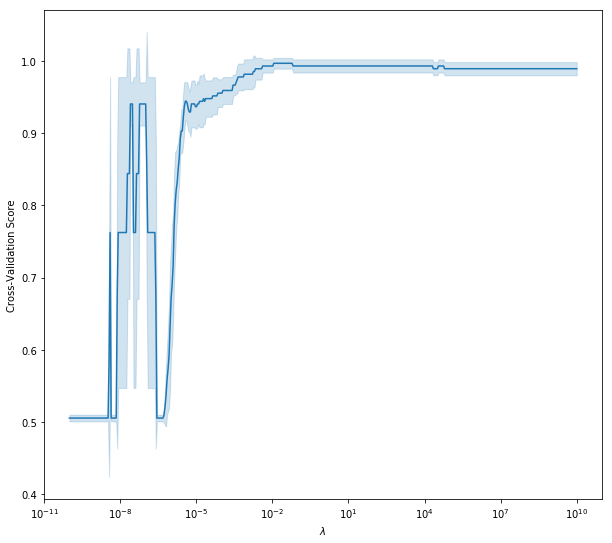

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(bdata, labels, random_state=42069)

cs = np.logspace(-10, 10, 500)

mu, sig = [], []

for c in cs:
    lr = LogisticRegression(C=c, max_iter=1000)

    scores = cross_val_score(lr, x_train, y_train, cv=5)

    mu.append(np.mean(scores))
    sig.append(np.std(scores))

mu = np.asarray(mu)
sig = np.asarray(sig)

# prefer high score with low std
i = np.argmax(mu - sig)
c = cs[i]

plt.figure(figsize=(10, 9))
plt.plot(cs, mu, color="C0")
plt.fill_between(cs, mu - sig, mu + sig, color="C0", alpha=0.2)
plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("Cross-Validation Score")
plt.show()

In [23]:
lr = LogisticRegression(C=c, max_iter=1000)

lr.fit(x_train, y_train)

classified = lr.predict(x_test)

incorrect = classified != y_test

print("Error Rate:", np.mean(incorrect.astype(float)))



Error Rate: 0.0


### 1.2 Optimization Methods

In [282]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def gradient(beta, X, y, lambd):
    # beta.T/lambda + 1/N*sum_i(sigma(-y_i X_i beta)(-y_i X_i))
    return beta.T/lambd + 1/len(y) * (sigmoid(-y*X.dot(beta))[:,np.newaxis] * (-y[:,np.newaxis]*X)).sum(axis=0)
    
def predict(beta, X):
    return np.sign(X.dot(beta))

def zero_one_loss(y_prediction, y_truth):
    return (y_prediction != y_truth).sum()


In [283]:
def gradient_descent(X, y, T, lambd, beta_0, tau):
    beta = beta_0
    for t in range(T):
        beta = beta - tau*gradient(beta, X, y, lambd)
    return beta

def SG(X, y, T, lambd, gamma, beta_0, tau_0):
    beta = beta_0
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        instance = [np.random.randint(len(y))]
        beta = beta - tau*gradient(beta, X[instance], y[instance], lambd)
    return beta
    
def SG_minibatch(X, y, T, lambd, gamma, B, beta_0, tau_0):
    beta = beta_0
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        instances = np.random.choice(len(y), size=B, replace=False)
        beta = beta - tau*gradient(beta, X[instances], y[instances], lambd)
    return beta

def SG_momentum(X, y, T, lambd, gamma, mu, beta_0, g_0, tau_0):
    beta = beta_0
    g = g_0
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        instance = [np.random.randint(len(y))]
        g = mu*g + (1-mu)*gradient(beta, X[instance], y[instance], lambd)
        beta = beta - tau*g
    return beta

def ADAM(X, y, T, lambd, mu_1, mu_2, beta_0, g_0, q_0, tau_0, epsilon):
    beta = beta_0
    g = g_0
    q = q_0
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        instance = [np.random.randint(len(y))]
        l = gradient(beta, X[instance], y[instance], lambd)
        g = mu_1*g + (1-mu_1)*l
        q = mu_2*q + (1-mu_2)*(l*l)
        g_ = g/(1-mu_1**(t+1))
        q_ = q/(1-mu_2**(t+1))
        beta = beta - tau/(np.sqrt(q_)+epsilon)*g_
    return beta

def SG_average(X, y, T, gamma, beta_0, tau_0):
    beta = beta_0
    s = sigmoid(-y*X.dot(beta_0))
    g_stored = (-y*X.T*(sigmoid(-y*X.dot(beta_0)))).T
    g = 1/len(y)*g_stored.sum(axis=0)
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        i = np.random.randint(len(y))
        g_i = -y[i]*X[i].T*(sigmoid(-y[i]*X[i].dot(beta)))
        g = g + 1/len(y)*(g_i - g_stored[i])
        g_stored[i] = g_i
        beta = beta*(1 - tau/c) - tau*g
        
    return beta
    
def dual_coordinate_ascent(X, y, T, lambd, epsilon, alpha_0):
    N = len(y)
    alpha = alpha_0
    beta = lambd/N * ((alpha_0*y)[:,np.newaxis]*X).sum(axis=0)
    for t in range(T):
        i = np.random.randint(len(y))
        f_ = y[i]*X[i].dot(beta) + np.log(alpha[i]/(1-alpha[i]))
        f__ = lambd/N*X[i].dot(X[i]) + 1/(alpha[i]*(1-alpha[i]))
        alpha_new = np.clip(alpha - f_/f__, epsilon, 1-epsilon)
        beta = beta + lambd/N*(y*X.T*(alpha_new-alpha)).sum(axis=1)
        alpha = alpha_new
        
    return beta
        
def Newton_Raphson(X, y, T, lambd, beta_0):
    N = len(y)
    D = X.shape[1]
    beta = beta_0
    for t in range(T):
        z = X.dot(beta)
        y_ = y/sigmoid(y*z)
        sigmoid_z = sigmoid(z)
        W = np.diag(lambd/N*sigmoid_z*(1-sigmoid_z))
        beta = np.linalg.inv(np.eye(D) + X.T.dot(W).dot(X)).dot(X.T.dot(W).dot(z+y_))
        
    return beta


### 1.3 Comparison

In [284]:
from sklearn.model_selection import train_test_split, KFold

X, X_test, y, y_test = train_test_split(bdata, labels, test_size=0.3, random_state=0)
(N, D) = X_train.shape
beta_0 = np.zeros(D)
g_0 = np.zeros(D)
q_0 = np.zeros(D)

kf = KFold(n_splits=10, shuffle=True)

tau_parameters = [0.0001, 0.001, 0.01, 0.1]
mu_parameters = [0.1, 0.2, 0.5]
gamma_parameters = [0.0001, 0.001, 0.01]
epsilon_parameters = [1e-8, 1e-7, 1e-6]


# gradient descent
errors = []
parameters = []
for tau in tau_parameters:
    error = 0
    for train_index, validation_index in kf.split(X):
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y[train_index], y[validation_index]

        beta = gradient_descent(X_train, y_train, 10, c, beta_0, tau)
        error += zero_one_loss(y_validation, predict(beta, X_validation))
        
    parameters.append(tau)
    errors.append(error)
print("\ngradient descent (tau)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")

# SG
errors = []
parameters = []
for tau in tau_parameters:
    for gamma in gamma_parameters:
        error = 0
        for train_index, validation_index in kf.split(X):
            X_train, X_validation = X[train_index], X[validation_index]
            y_train, y_validation = y[train_index], y[validation_index]

            beta = SG(X_train, y_train, 150, c, gamma, beta_0, tau)
            error += zero_one_loss(y_validation, predict(beta, X_validation))

        parameters.append((tau, gamma))
        errors.append(error)
        
print("\nSG (tau, gamma)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# SG minibatch
errors = []
parameters = []
for tau in tau_parameters:
    for gamma in gamma_parameters:
        error = 0
        for train_index, validation_index in kf.split(X):
            X_train, X_validation = X[train_index], X[validation_index]
            y_train, y_validation = y[train_index], y[validation_index]

            beta = SG_minibatch(X_train, y_train, 150, c, gamma, 50, beta_0, tau)
            error += zero_one_loss(y_validation, predict(beta, X_validation))

        parameters.append((tau, gamma))
        errors.append(error)
        
print("\nSG_minibatch (tau, gamma)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# SG momentum
errors = []
parameters = []
for tau in tau_parameters:
    for mu in mu_parameters:
        for gamma in gamma_parameters:
            error = 0
            for train_index, validation_index in kf.split(X):
                X_train, X_validation = X[train_index], X[validation_index]
                y_train, y_validation = y[train_index], y[validation_index]

                beta = SG_momentum(X_train, y_train, 150, c, gamma, mu, beta_0, g_0, tau)
                error += zero_one_loss(y_validation, predict(beta, X_validation))

            parameters.append((tau, mu, gamma))
            errors.append(error)
        
print("\nSG_momentum (tau, mu, gamma)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# ADAM
errors = []
parameters = []
for tau in tau_parameters:
    error = 0
    for train_index, validation_index in kf.split(X):
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y[train_index], y[validation_index]

        beta = ADAM(X_train, y_train, 150, c, 0.9, 0.999, beta_0, g_0, q_0, tau, 1e-8)
        error += zero_one_loss(y_validation, predict(beta, X_validation))

    parameters.append(tau)
    errors.append(error)
        
print("\nADAM (tau)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# SG_average
errors = []
parameters = []
for tau in tau_parameters:
    error = 0
    for train_index, validation_index in kf.split(X):
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y[train_index], y[validation_index]

        beta = SG_average(X_train, y_train, 150, c, beta_0, tau)
        error += zero_one_loss(y_validation, predict(beta, X_validation))

    parameters.append(tau)
    errors.append(error)
        
print("\nSG_average (tau)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# dual_coordinate_ascent
errors = []
parameters = []
for epsilon in epsilon_parameters:
    error = 0
    for train_index, validation_index in kf.split(X):
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y[train_index], y[validation_index]

        alpha_0 = np.random.uniform(size=X_train.shape[0])

        beta = dual_coordinate_ascent(X_train, y_train, 150, c, epsilon, alpha_0)
        error += zero_one_loss(y_validation, predict(beta, X_validation))

    parameters.append(epsilon)
    errors.append(error)
        
print("\ndual_coordinate_ascent (epsilon)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# Newton_Raphson
errors = []
parameters = []
error = 0
for train_index, validation_index in kf.split(X):
    X_train, X_validation = X[train_index], X[validation_index]
    y_train, y_validation = y[train_index], y[validation_index]

    beta = Newton_Raphson(X_train, y_train, 10, c, beta_0)
    error += zero_one_loss(y_validation, predict(beta, X_validation))

errors.append(error)
        
print("\nNewton_Raphson (no hyperparameters)")
print(errors)

C:\Users\nwolf\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



gradient descent (tau)
[0.0001, 0.001, 0.01, 0.1]
[17, 14, 105, 195]
best (error:14): 0.001

SG (tau, gamma)
[(0.0001, 0.0001), (0.0001, 0.001), (0.0001, 0.01), (0.001, 0.0001), (0.001, 0.001), (0.001, 0.01), (0.01, 0.0001), (0.01, 0.001), (0.01, 0.01), (0.1, 0.0001), (0.1, 0.001), (0.1, 0.01)]
[23, 45, 40, 101, 81, 65, 120, 130, 139, 127, 119, 135]
best (error:23): (0.0001, 0.0001)

SG_minibatch (tau, gamma)
[(0.0001, 0.0001), (0.0001, 0.001), (0.0001, 0.01), (0.001, 0.0001), (0.001, 0.001), (0.001, 0.01), (0.01, 0.0001), (0.01, 0.001), (0.01, 0.01), (0.1, 0.0001), (0.1, 0.001), (0.1, 0.01)]
[15, 16, 14, 17, 14, 15, 117, 105, 120, 155, 146, 123]
best (error:14): (0.0001, 0.01)

SG_momentum (tau, mu, gamma)
[(0.0001, 0.1, 0.0001), (0.0001, 0.1, 0.001), (0.0001, 0.1, 0.01), (0.0001, 0.2, 0.0001), (0.0001, 0.2, 0.001), (0.0001, 0.2, 0.01), (0.0001, 0.5, 0.0001), (0.0001, 0.5, 0.001), (0.0001, 0.5, 0.01), (0.001, 0.1, 0.0001), (0.001, 0.1, 0.001), (0.001, 0.1, 0.01), (0.001, 0.2, 0.0001)

In [285]:

X_train, X_test, y_train, y_test = train_test_split(bdata, labels, test_size=0.3, random_state=0)
errors = np.zeros(8)
for i in range(100):
    tau = 0.001
    beta = gradient_descent(X_train, y_train, 10, c, beta_0, tau)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[0] += error
    
    tau, gamma = 0.0001, 0.0001
    beta = SG(X_train, y_train, 150, c, gamma, beta_0, tau)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[1] += error
    
    tau, gamma = 0.0001, 0.01
    beta = SG_minibatch(X_train, y_train, 150, c, gamma, 100, beta_0, tau)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[2] += error

    tau, mu, gamma = 0.0001, 0.1, 0.01
    beta = SG_momentum(X_train, y_train, 150, c, gamma, mu, beta_0, g_0, tau)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[3] += error
    
    tau = 0.001
    beta = ADAM(X_train, y_train, 150, c, 0.9, 0.999, beta_0, g_0, q_0, tau, 1e-8)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[4] += error
    
    tau = 0.01
    beta = SG_average(X_train, y_train, 150, c, beta_0, tau)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[5] += error
    
    epsilon = 1e-07
    alpha_0 = np.random.uniform(size=X_train.shape[0])
    beta = dual_coordinate_ascent(X_train, y_train, 150, c, epsilon, alpha_0)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[6] += error
    
    beta = Newton_Raphson(X_train, y_train, 10, c, beta_0)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[7] += error
    
print(errors/100)
                

[ 2.   10.85  1.86  5.2   6.51  2.07  4.99  2.  ]


### Speed

In [286]:
X_train, X_test, y_train, y_test = train_test_split(bdata, labels, test_size=0.3, random_state=0)
N_train, D = X_train.shape
N_test, D = X_test.shape
B = 100

T_max = 300
training_errors = np.zeros((8, T_max))
test_errors = np.zeros((8, T_max))
for T in range(T_max):
    if T % 100 == 0:
        print(T)
    tau = 0.001
    beta = gradient_descent(X_train, y_train, T, c, beta_0, tau)
    training_errors[0][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[0][T] = zero_one_loss(y_test, predict(beta, X_test))

    tau, gamma = 0.001, 0.01
    beta = SG(X_train, y_train, T, c, gamma, beta_0, tau)
    training_errors[1][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[1][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    tau, gamma = 0.001, 0.0001
    beta = SG_minibatch(X_train, y_train, T, c, gamma, B, beta_0, tau)
    training_errors[2][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[2][T] = zero_one_loss(y_test, predict(beta, X_test))

    tau, mu, gamma = 0.0001, 0.5, 0.0001
    beta = SG_momentum(X_train, y_train, T, c, gamma, mu, beta_0, g_0, tau)
    training_errors[3][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[3][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    tau = 0.001
    beta = ADAM(X_train, y_train, T, c, 0.9, 0.999, beta_0, g_0, q_0, tau, 1e-8)
    training_errors[4][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[4][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    tau = 0.001
    beta = SG_average(X_train, y_train, T, c, beta_0, tau)
    training_errors[5][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[5][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    epsilon = 1e-08
    alpha_0 = np.random.uniform(size=X_train.shape[0])
    beta = dual_coordinate_ascent(X_train, y_train, T, c, epsilon, alpha_0)
    training_errors[6][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[6][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    beta = Newton_Raphson(X_train, y_train, T, c, beta_0)
    training_errors[7][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[7][T] = zero_one_loss(y_test, predict(beta, X_test))

    
training_errors /= N_train
test_errors /= N_test


0
100
200


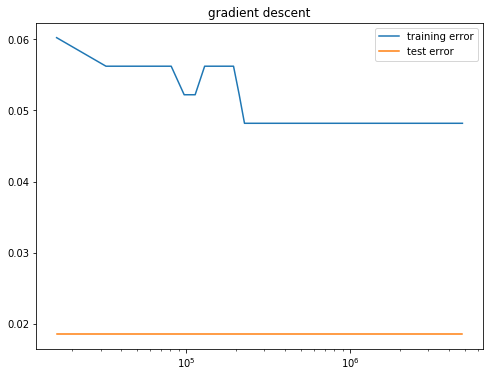

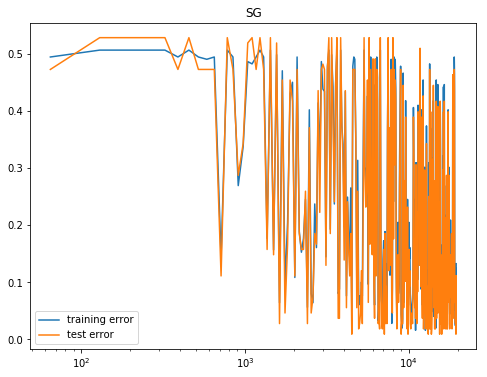

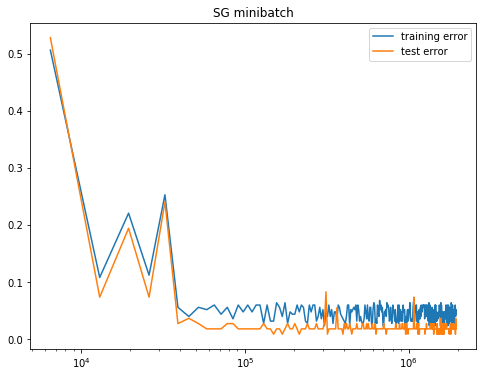

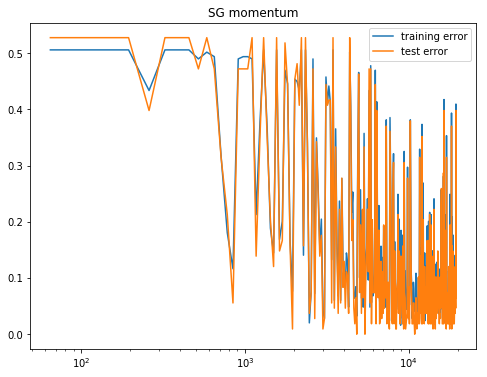

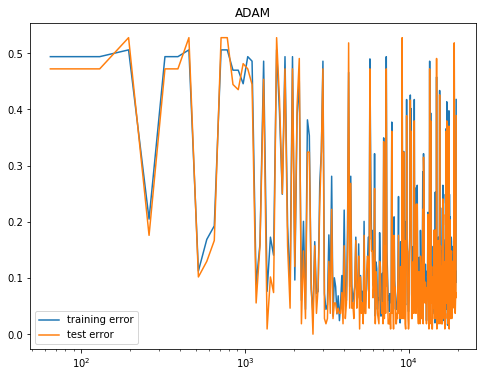

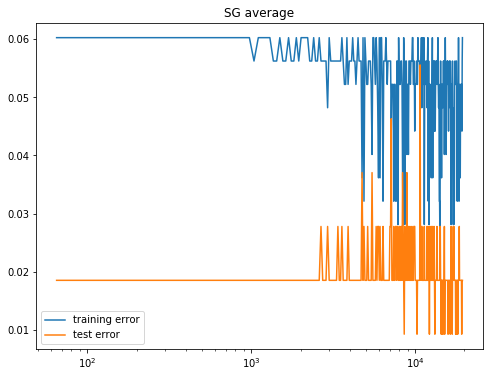

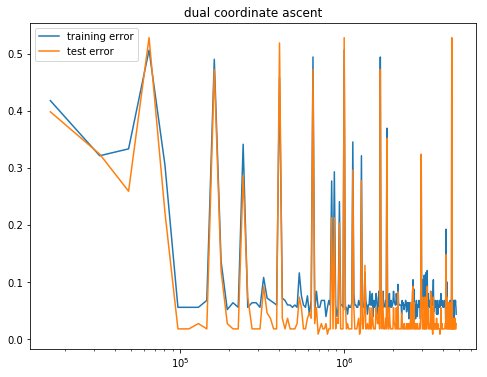

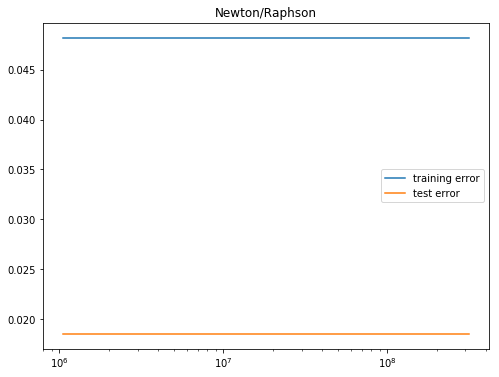

In [293]:
complexities = [N_train*D, D, B*D, D, D, D, N_train*D, N_train*D*D]
titles = ["gradient descent", "SG", "SG minibatch", "SG momentum", "ADAM", "SG average", "dual coordinate ascent", "Newton/Raphson"]

for i in range(8):
    plt.figure(figsize=(8,6))
    T = np.arange(1,T_max)*complexities[i]
    plt.plot(T, training_errors[i][1:], label="training error")
    plt.plot(T, test_errors[i][1:], label="test error")
    plt.title(titles[i])
    #plt.yscale('log')
    plt.xscale('log')
    plt.legend()